### Import package

In [1]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(2)
tf.set_random_seed(2)

%matplotlib inline

ModuleNotFoundError: No module named 'gym'

### Hyperparameter

In [2]:
MAX_EPISODE = 500 # 要跑多少個 episode
MAX_EP_STEPS = 200 # 一個 episode 要跑多少步
DISPLAY_REWARD_THRESHOLD = -60 # 如果 reward 大於這個 threshold 就 render 環境
RENDER = False # 一開始先不要 render，因為會浪費時間
GAMMA = 0.95 # reward discount factor
LR_A = 0.0001 # learning rate for actor
LR_C = 0.001 # learning rate for critic

USE_ACTION_AS_INPUT = False # whether to use action as input for critic

### Environment Settings

In [3]:
ENV_NAME = "Pendulum-v0"
env = gym.make(ENV_NAME)
env.seed(1) # reproducible

n_obs = env.observation_space.shape[0]
is_discrete = hasattr(env.action_space, "n")

if is_discrete:
    n_action_space = env.action_space.n
else:
    n_action_space = env.action_space.shape[0]
print("The number of observation is: %s The number of action that can be taken is: %s (%s)" % \
      (n_obs, n_action_space, "discrete" if is_discrete else "continuous"))

if not is_discrete:
    action_bound = env.action_space.high
    print("Action boundary: %s ~ %s" % (env.action_space.low[0], env.action_space.high[0]))

[1]

<img src="img/actor_critic_pseudo.JPG",width=400,height=200>

### Actor-Critic
以下程式碼我們做了挖空的處理，註解有 `###` 的部分就要請你練習寫出來的地方

In [5]:
class ActorCritic(object):
    def __init__(self, n_action_space, n_state, action_bound, sess):
        
        self.n_action_space = n_action_space
        self.n_state = n_state
        self.action_bound = action_bound
        self.sess = sess
        
        self.S = tf.placeholder(tf.float32, [1, self.n_state], 'state_input')
        self.gt_action = tf.placeholder(tf.float32, None, 'gt_action')
        self.td_error = tf.placeholder(tf.float32, None, name="td_error")  # TD_error
        
        self.R = tf.placeholder(tf.float32, name='reward')
        self.v_ = tf.placeholder(tf.float32, [1, 1], 'next_exp_v')
        
        with tf.variable_scope("Actor"):
            # create actor network
            self.action, self.normal_dist = self.create_actor(self.S)
            
            with tf.name_scope("expected_value_for_actor"):
                ### 請定義 self.exp_v
                # create_actor: normal_dist = tf.distributions.Normal(tf.squeeze(mu*2), tf.squeeze(sigma + 1e-5))
                # actor gradient = grad[logP_Pi(a|s) * td_error]
                self.exp_v = self.normal_dist.log_prob(self.gt_action) * self.td_error
                self.exp_v = self.exp_v - 0.01 * self.normal_dist.entropy() # Add cross entropy cost to encourage exploration
            
            with tf.name_scope("actor_train"):
                ### 請定義 self.actor_train
                # wish to maximize Q value, i.e., self.exp_v in our case
                # Note: min(-v) = max(v)
                self.actor_train = 
        
        with tf.variable_scope("Critic"):
            # create critic network
            self.v = self.create_critic(self.S, self.gt_action)
            
            with tf.name_scope("squared_TD_error"):
                ### 請定義 critic_v_target 及 self.critic_td_error
                # critic gradient = grad[r + gamma * V(s_) - V(s)]
                critic_v_target = 
                self.critic_td_error = 
                self.loss = tf.square(self.critic_td_error)
            
            with tf.name_scope("critic_train"):
                ### 請定義 self.critic_train
                # wish to minimize the td error
                self.critic_train = 
                
    def choose_action(self, s):
        s = s[np.newaxis, :]
        ### 請回傳 action
        return  # return a action with continuous real number
    
    def create_actor(self, s):
        ### 請嘗試寫一個簡單的 actor network，
        ### 輸入是 state (s)，輸出是 action 以及 action 的 distribution
        ### 只需要有 1 層、30 units 的 dense layer (當然你也可以去 try 更複雜架構)
        l1 = 
        mu = 
        sigma = 
        normal_dist = 
    
        action = 
        return action, normal_dist
        
    def update_actor(self, s, a , td):
        s = s[np.newaxis, :]
        feed_dict = {self.S: s, self.gt_action: a, self.td_error: td}
        _, exp_v = self.sess.run([self.actor_train, self.exp_v], feed_dict)
        return exp_v
        
    def create_critic(self, s, a):
        ### 請嘗試寫一個簡單的 critic network,
        ### 輸入是 state (s)，如果 USE_ACTION_AS_INPUT == True 的話，輸入是 s + a
        ### 輸出 value
        l1 = 
        if USE_ACTION_AS_INPUT:
            a = tf.reshape(a, (1, 1)) # reshape action to (1, 1) to concat properly
            l2 = 
            v = 
        else:
            v = 

        return v
    
    def update_critic(self, s, r, s_, a=None):
        s, s_ = s[np.newaxis, :], s_[np.newaxis, :]

        if a is None:
            v_ = self.sess.run(self.v, {self.S: s_})
            td_error, _ = self.sess.run([self.critic_td_error, self.critic_train],
                                              {self.S: s, self.v_: v_, self.R: r})
        else:
            v_ = self.sess.run(self.v, {self.S: s_, self.gt_action: a})
            td_error, _ = self.sess.run([self.critic_td_error, self.critic_train],
                                              {self.S: s, self.gt_action: a, self.v_: v_, self.R: r})
            
        return td_error


### Initial our Actor-Critic

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

actor_critic = ActorCritic(n_action_space, n_obs, action_bound, sess)

sess.run(tf.global_variables_initializer())

### Main training

In [ ]:
reward_history = []
for i_episode in range(MAX_EPISODE):
    s = env.reset()
    t, ep_rs = 0, 0
    while True:
        if RENDER:
            env.render()
        ### 請計算 given state 得到的 action
        a = 
        s_, r, done, info = env.step(a)
        r /= 10 # scaled reward to converge faster
        ### 請更新 critic 並且計算 td_error
        if USE_ACTION_AS_INPUT:
            td_error = 
        else:
            td_error =  # critic gradient = grad[r + gamma * V(s_) - V(s)]
        ### 請更新 actor
        # actor gradient = grad[logP_Pi(a|s) * td_error]

        s = s_
        t += 1
        ep_rs += r
        
        if t > MAX_EP_STEPS:
            reward_history.append(ep_rs)
            if 'running_reward' not in globals():
                running_reward = ep_rs
            else:
                running_reward = running_reward * 0.9 + ep_rs * 0.1 # 希望是穩定的 reward
            
            if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True  # rendering
            print("episode:", i_episode, "  reward:", int(running_reward))
            break

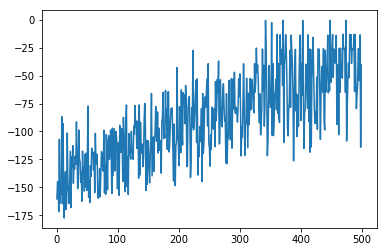

In [8]:
plt.plot(reward_history)

### Save model

In [9]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()
# Save the variables to disk.
save_path = saver.save(sess, "checkpoint/ac_v1.ckpt")

### Use checkpoint
這裡有幫大家跑好 `USE_ACTION_AS_INPUT = False` 的 model，有興趣的話可以 restore ac.ckpt 這個 checkpoint 來玩 pendulum。

In [10]:
saver.restore(sess, "checkpoint/ac_v1.ckpt")
s = env.reset()
i_step = 0
while True:
    env.render()
    a = actor_critic.choose_action(s)
    s_, r, done, info = env.step(a)
    s = s_
    i_step += 1
    if i_step > 300:
        break

INFO:tensorflow:Restoring parameters from checkpoint/ac_v1.ckpt
